In [21]:
import networkx as nx
import osmnx as ox
import numpy as np
import warnings
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
 
logging.basicConfig(filename = 'planner.log',
                    filemode="w",
                    level = logging.DEBUG,
                    format = '%(asctime)s:%(levelname)s:%(name)s:%(message)s')

logging.info("Start of the program")

warnings.filterwarnings('ignore')

In [22]:
# MAP_PATH = "./data/london.graphml"
# MAP_TUBE_PATH = "./data/london_tube.graphml"

# LONDON_NORTH, LONDON_SOUTH, LONDON_EAST, LONDON_WEST = 51.672343, 51.384940, 0.148271, -0.351468

ACCEPTABLE_WALKING_DISTANCE = 1000 # 1 km
ACCEPTABLE_WALKING_TIME = 15 * 60 # 15 minutes

ENTRY_PENALTY = 4
TRANSFERS_PENALTY = 3.9
WK_WEIGHT = 8.46
# WK_WEIGHT = 0.8

DRAW_MAP = True

WALKING_SPEED = 1.34112 # m/s
WALKING_SPEED_YOUNG = 1.45 # m/s
WALKING_SPEED_OLD = 1.19 # m/s

tube_speeds = [27.04, 37.29, 24.31, 29.44, 27.65, 40.32, 44.14, 34.09, 32.65, 42.49, 33.30] # km/h
TRANSPORT_SPEED =  np.mean(tube_speeds) / 3.6 # km/h to m/s

user_group = ''

Operating tubes Average Speed in London (km/h):
- Bakerloo: 27.04
- Central: 37.29
- Circle: 24.31
- District: 29.44
- Hammersmith and City: 27.65
- Jubilee: 40.32
- Metropolitan: 44.14
- Northern: 34.09
- Piccadilly: 32.65
- Victoria: 42.49
- Waterloo and City: 33.30

In [23]:
# origin_address = "Finchley Road Station, London, UK"
# dest_address = "Covent Garden, London, UK"

# origin_address = "Wembley Park Station, London, UK"
# dest_address = "Covent Garden, London, UK"

# origin_address = "Finchley Road Station, London, UK"
# dest_address = "Bush House, London, UK"

# origin_address = "Finchley Road Station, London, UK"
# dest_address = "Bush House, London, UK"

origin_address = "Paddington Station, London, UK"
dest_address = "Bush House, London, UK"

# origin_address = "Madame Tussauds London, London, UK"
# dest_address = "Park Royal, London, UK"

# origin_address = "Lancaster Gate, London, UK"
# dest_address = "Natural History Museum, London, UK"

# origin_address = "Euston Station, London, UK"
# dest_address = "Natural History Museum, London, UK"

# origin_address = "Canary Wharf Station, London, UK"
# dest_address = "British Museum, London, UK"

# origin_address = "Liverpool Street, London, UK"
# dest_address = "Covent Garden, London, UK"

# origin_address = "London Bridge, London, UK"
# dest_address = "King's College Hospital, London, UK"

# origin_address = "Saatchi Gallery, London, UK"
# dest_address = "Camden Market, London, UK"

# origin_address = "Chalk Farm, London, UK"
# dest_address = "Park Royal, London, UK"

# origin_address = "Hampstead Heath, London, UK"
# dest_address = "Park Royal, London, UK"

# origin_address = "Madame Tussauds London, London, UK"
# dest_address = "St. Paul's Cathedral, London, UK"

# origin_address = "Westfield London, London, UK"
# dest_address = "London Zoo, London, UK"

# origin_address = "Baker Street, London, UK"
# dest_address = "Covent Garden, London, UK"

# origin_address = "Waitrose and Partners Marylebone, London, UK"
# dest_address = "Leicester Square, London, UK"

# origin_address = "Lancaster Gate, London, UK"
# dest_address = "Thistle Trafalgar Square, London, UK"

# origin_address = "Hampstead, London, UK"
# dest_address = "Westfield London, London, UK"

# origin_address = "National Theatre, London, UK"
# dest_address = "Nottinghill Gate, London, UK"

# origin_address = ", London, UK"
# dest_address = ", London, UK"

# origin_address = ", London, UK"
# dest_address = ", London, UK"


address_compact = origin_address.split(",")[0].replace(" ", "_") + '-' + dest_address.split(",")[0].replace(" ", "_")
origin_lat, origin_lon = ox.geocode(origin_address)
dest_lat, dest_lon = ox.geocode(dest_address)

In [24]:
# define bundries of the map to be downloaded by origin and destination coordinates
def get_bbox_bound_from_coord(lat1, lon1, lat2, lon2, diff=0.04):
    north, south, east, west = -100, 100, -100, 100
    if lat1 > north: north = lat1
    if lat2 > north: north = lat2
    if lat1 < south: south = lat1
    if lat2 < south: south = lat2
    if lon1 > east: east = lon1
    if lon2 > east: east = lon2
    if lon1 < west: west = lon1
    if lon2 < west: west = lon2
    
    return north+diff, south-diff, east+diff, west-diff

In [25]:
# north, south, east, west = 51.55, 51.47, -0.22, -0.021

# download the map
north, south, east, west = get_bbox_bound_from_coord(origin_lat, origin_lon, dest_lat, dest_lon)
G = ox.graph_from_bbox(north, south, east, west, network_type="walk")


# ox.save_graphml(G, MAP_PATH)

In [26]:
# define origin and destination nodes on the map
origin, dist1 = ox.nearest_nodes(G, origin_lon, origin_lat, return_dist=True)
dest, dist2 = ox.nearest_nodes(G, dest_lon, dest_lat, return_dist=True)

In [27]:
# add weights to walking edges based on age/gender
for u, v, k, data in G.edges(data=True, keys=True):
    distance = data["length"]
    data["time"] = round(distance / WALKING_SPEED) * WK_WEIGHT
    data["time_young"] = round(distance / WALKING_SPEED_YOUNG) * WK_WEIGHT
    data["time_old"] = round(distance / WALKING_SPEED_OLD) * WK_WEIGHT
    
    # print(f"take {data['time']} secs to walk {data['length']} m")
    # data["time_male"] = round(distance / WALKING_SPEED_MALE) * WK_WEIGHT
    # data["time_female"] = round(distance / WALKING_SPEED_FEMALE)  * WK_WEIGHT

G_wk = G.copy()

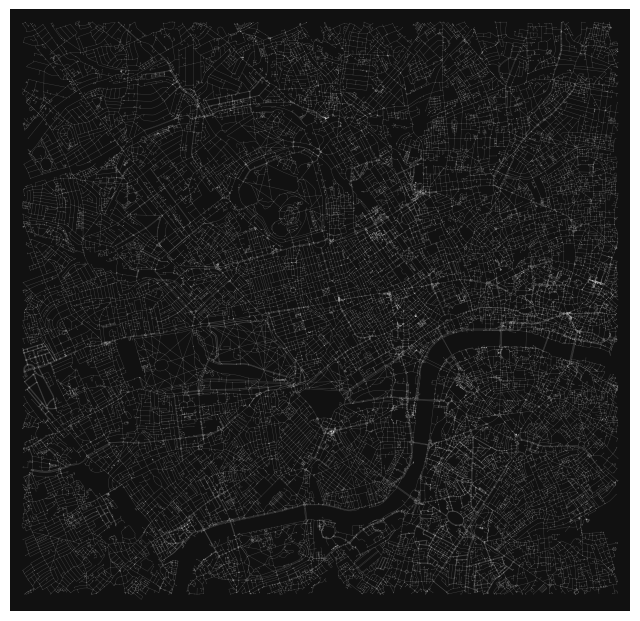

In [28]:
fig, ax = ox.plot_graph(G_wk, node_color='w', node_alpha=.3, node_size=.2, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.3, dpi=300)
fig.savefig(f"output_osmnx_paths/walk_map_{address_compact}.png", dpi=300, bbox_inches='tight')

In [29]:
import json

with open('input/LondonTubeLines_minimal.json', 'r') as f:
    data = json.load(f)

station_transfer_nodes = {}
added_nodes_name, stations_osmid = set(), set()

# add new station transfer nodes based on stations locations
# For example: 'Baker Street [Metropolitan]', 'Baker Street [Jubilee]', 'Baker Street [Bakerloo]'
for tube_route in data['features']:
    start_end = tube_route['geometry']['coordinates']
    orig_lon, orig_lat = start_end[0][0], start_end[0][1]
    end_lon, end_lat = start_end[1][0], start_end[1][1]

    orig_node, dist1 = ox.nearest_nodes(G, orig_lon, orig_lat, return_dist=True)
    end_node, dist2 = ox.nearest_nodes(G, end_lon, end_lat, return_dist=True)

    # ignore stations and routes that are not within 50m of the graph
    if dist1 > 50 or dist2 > 50:
        continue

    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    # prepare for station search later
    G.nodes[orig_node]['station_name'] = start_station_name
    G.nodes[end_node]['station_name'] = end_station_name
    stations_osmid.add(orig_node)
    stations_osmid.add(end_node)

    start_node_name = f"{start_station_name} [{line_name}]"
    end_node_name = f"{end_station_name} [{line_name}]"

    if not start_node_name in added_nodes_name:
        new_node = (start_node_name, {'x': G.nodes[orig_node]['x'], 'y': G.nodes[orig_node]['y'], 'type':'tube_station'})
        try:
            station_transfer_nodes[orig_node].append(new_node)
        except (KeyError, AttributeError) as e:
            station_transfer_nodes[orig_node] = [new_node]
        logging.debug(f"{orig_node} add {start_node_name}")
        added_nodes_name.add(start_node_name)
    
    if not end_node_name in added_nodes_name:
        new_node = (end_node_name, {'x': G.nodes[end_node]['x'], 'y': G.nodes[end_node]['y'], 'type':'tube_station'})
        try:
            station_transfer_nodes[end_node].append(new_node)
        except (KeyError, AttributeError) as e:
            station_transfer_nodes[end_node] = [new_node]
        
        logging.debug(f"{end_node} add {end_node_name}")
        added_nodes_name.add(end_node_name)


In [30]:
for station in station_transfer_nodes:
    station_transfers = []
    # add entrances to the station transfer nodes
    for node in station_transfer_nodes[station]:
        G.add_node(node[0], **node[1])
        logging.debug(f"added node {node[0]}: {G.nodes[node[0]]}")
        G.add_edge(station, node[0], **{'length': 0, 'time': ENTRY_PENALTY*60, 'time_young': ENTRY_PENALTY*60, 'time_old': ENTRY_PENALTY*60, 'type': 'entrance'})
        G.add_edge(node[0], station, **{'length': 0, 'time': ENTRY_PENALTY*60, 'time_young': ENTRY_PENALTY*60, 'time_old': ENTRY_PENALTY*60, 'type': 'entrance'})
        logging.debug(f"entrance added: {station} -> {node[0]} {G.edges[station, node[0], 0]}")
        station_transfers.append(node[0])

    # add edges between station transfers 
    # e.g. Baker Street [Metropolitan] <-> Baker Street [Jubilee]
    #      Baker Street [Metropolitan] <-> Baker Street [Bakerloo]
    #      Baker Street [Metropolitan] <-> Baker Street [Hammersmith & City]
    #      Baker Street [Jubilee] <-> Baker Street [Hammersmith & City]
    #      Baker Street [Jubilee] <-> Baker Street [Bakerloo]
    #      Baker Street [Bakerloo] <-> Baker Street [Hammersmith & City]
    for i in range(len(station_transfers)):
        for j in range(i+1, len(station_transfers)):
            G.add_edge(station_transfers[i], station_transfers[j], **{'length': 0, 'time': TRANSFERS_PENALTY*60, 'time_young': TRANSFERS_PENALTY*60, 'time_old': TRANSFERS_PENALTY*60, 'type': 'transfer'})
            G.add_edge(station_transfers[j], station_transfers[i], **{'length': 0, 'time': TRANSFERS_PENALTY*60, 'time_young': TRANSFERS_PENALTY*60, 'time_old': TRANSFERS_PENALTY*60, 'type': 'transfer'})
            logging.debug(f"transfer added: {station_transfers[i]} -> {station_transfers[j]} {G.edges[station_transfers[j], station_transfers[i], 0]}")

In [31]:
# add tube lines
# diff tube lines are seperate from each other
tube_lines, route_colors = [], []
for tube_route in data['features']:
    line_color = tube_route['properties']['stroke']
    feature_str = tube_route['properties']['name'].split(' - ')
    line_name = feature_str[0]
    start_station_name = feature_str[1].split(' to ')[0].split(' (')[0]
    end_station_name = feature_str[1].split(' to ')[1].split(' (')[0]

    start_node_name = f"{start_station_name} [{line_name}]"
    end_node_name = f"{end_station_name} [{line_name}]"

    if start_node_name in added_nodes_name and end_node_name in added_nodes_name:
        G.add_edge(start_node_name, end_node_name, color=line_color)
        G.add_edge(end_node_name, start_node_name, color=line_color)

        logging.debug(f"connecting: {start_node_name} to {end_node_name}")
        
        tube_lines.append(nx.shortest_path(G, start_node_name, end_node_name))
        route_colors.append(line_color)

# logging.debug(f"all station info been added\n")
ox.distance.add_edge_lengths(G)

In [32]:
# add weight to tp edges
for u, v, k, data in G.edges(data=True, keys=True):
    if 'time' not in data:
        data["time"] = data["time_young"] = data["time_old"] = round(data["length"] / TRANSPORT_SPEED, 2)
    #     data['travel_mode'] = 'tp'
    #     logging.debug(f"add tp time{data}")
        # data["time"] = data["time_male"] = data["time_female"] = data["time_young"] = data["time_old"] = data["length"] / TRANSPORT_SPEED
        # print(f"distance: {round(data['length'], 3)} m \ttp time: {round(data['time'], 3)} seconds")
        # print(u, v, data)

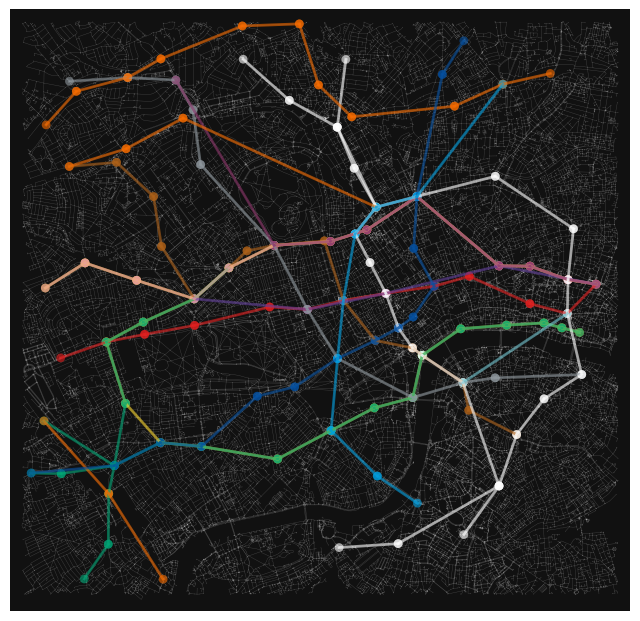

In [33]:
# plot london tube maps on top of walking map
if DRAW_MAP:
    fig, ax = ox.plot_graph_routes(G, tube_lines, route_linewidths=2, route_colors=route_colors, route_alpha=.6, \
                                node_color='w', node_alpha=.3, node_size=.2, orig_dest_size=40, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.3, \
                                dpi=300)

    fig.savefig(f"output_osmnx_paths/tube_map_{address_compact}.png", dpi=300, bbox_inches='tight')

In [34]:
# get route colors based on start and end nodes
# color: tube lines
# springgreen: walking
def get_route_colors(G, route):
    route_colors, route_chunks = [], []
    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        route_chunks.append([start_node, end_node])
        if 'color' in G.edges[start_node, end_node, 0]:
            route_colors.append(G.edges[start_node, end_node, 0]['color'])
        else:
            route_colors.append('springgreen')

    return route_chunks, route_colors

In [35]:
# define bundries of the map based on the route
def get_bbox_bound(node_list):
    north, south, east, west = -100, 100, -100, 100
    for node in node_list:
        if G.nodes[node]['y'] > north:
            north = G.nodes[node]['y']
        if G.nodes[node]['y'] < south:
            south = G.nodes[node]['y']
        if G.nodes[node]['x'] > east:
            east = G.nodes[node]['x']
        if G.nodes[node]['x'] < west:
            west = G.nodes[node]['x']
    diff_h = 0.01
    diff_v = 0.01
    return north+diff_h, south-diff_h, east+diff_v, west-diff_v


In [36]:
# output route description based on the route given
# along with tp_time and wk_time
def get_route_description(G, route, total_wk_time=0, total_tp_time=0, transfer=0):
    description = f"Start at : {origin_address}"
    description_time = ""

    last_travel_mode = 'walk'
    last_station = ''

    for i in range(len(route)-1):
        start_node, end_node = route[i], route[i+1]
        if 'type' in G.nodes[start_node] and G.nodes[start_node]['type'] == 'tube_station' \
            and 'type' in G.nodes[end_node] and G.nodes[end_node]['type'] == 'tube_station':
            tube_line = start_node.split(' [')[1].split(']')[0]
            station1 = start_node.split(' [')[0]
            station2 = end_node.split(' [')[0]
            
            if last_travel_mode != 'walk' and last_travel_mode != tube_line:
                description = "\n".join([description, f"   -> to [{last_station}]"])
            last_station = station2
            travel_mode = tube_line
            # record tp time
            total_tp_time += G.edges[start_node, end_node, 0]["time" + user_group]
        elif ('type' in G.nodes[start_node] and G.nodes[start_node]['type'] == 'tube_station') \
            or ('type' in G.nodes[end_node] and G.nodes[end_node]['type'] == 'tube_station'):
            # elif on transfer edges, wk_weight is not applied
            travel_mode = 'walk'
            # record wk (transfer) time
            total_wk_time += G.edges[start_node, end_node, 0]["time" + user_group]
        else:
            travel_mode = 'walk'
            # record wk time
            total_wk_time += G.edges[start_node, end_node, 0]["time" + user_group]/WK_WEIGHT
        
        if last_travel_mode != travel_mode:
            transfer += 1
            if last_travel_mode == 'walk':
                description = "\n".join([description, f"{transfer}. 🚄 From [{station1}] take {tube_line} line"])
            elif travel_mode == 'walk':
                if last_station != '':
                    description = "\n".join([description, f"   -> Get off at [{last_station}]"])
                description = "\n".join([description, f"{transfer}. 🚶🏻 Walk"])
            else:
                description = "\n".join([description, f"{transfer}. 🚄 Change at [{station1}] to {tube_line} line"])

        last_travel_mode = travel_mode

    total_wk_time = round(total_wk_time/60, 2)
    total_tp_time = round(total_tp_time/60, 2)
        
    description = "\n".join([description, f"Reaching destination: {dest_address}\n"])
    description = "\n".join([description, f"Transfers: {transfer} times"])
    
    description_time = "\n".join([description_time, f"Total wk time: {total_wk_time} minutes {user_group}"])
    description_time = "\n".join([description_time, f"Total tp time: {total_tp_time} minutes"])
    description_time = "\n".join([description_time, f"Total time: {total_wk_time + total_tp_time:.2f} minutes\n"])

    return total_wk_time, total_tp_time, transfer, description, description_time

Start at : Paddington Station, London, UK
1. 🚄 From [Paddington] take Bakerloo line
   -> to [Embankment]
2. 🚄 Change at [Embankment] to Circle line
   -> Get off at [Temple]
3. 🚶🏻 Walk
Reaching destination: Bush House, London, UK

Transfers: 3 times

Total wk time: 8.92 minutes 
Total tp time: 13.25 minutes
Total time: 22.17 minutes

Start at : Paddington Station, London, UK
1. 🚄 From [Paddington] take Bakerloo line
   -> to [Embankment]
2. 🚄 Change at [Embankment] to Circle line
   -> Get off at [Temple]
3. 🚶🏻 Walk
Reaching destination: Bush House, London, UK

Transfers: 3 times

Total wk time: 9.58 minutes _old
Total tp time: 13.25 minutes
Total time: 22.83 minutes


Total wk time: 8.57 minutes _young
Total tp time: 13.25 minutes
Total time: 21.82 minutes



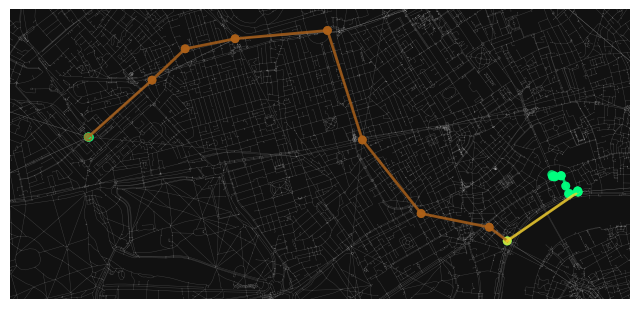

In [41]:
# compute the shortest path with the custom weights
user_group = ''
route_1 = nx.shortest_path(G, origin, dest, weight='time') # print(route)
total_wk_time, total_tp_time, transfer, description, description_time = get_route_description(G, route_1)
print(description)
print(description_time)

user_group = '_old'
route_2 = nx.shortest_path(G, origin, dest, weight='time'+user_group) # print(route)
total_wk_time, total_tp_time, transfer, description, description_time = get_route_description(G, route_2)
if route_1 != route_2:
    print(description)
print(description_time)
    

user_group = '_young'
route_3 = nx.shortest_path(G, origin, dest, weight='time'+user_group) # print(route)
total_wk_time, total_tp_time, transfer, description, description_time = get_route_description(G, route_3)
if route_1 != route_3:
    print(description)
print(description_time)

route_chunks, route_colors = get_route_colors(G, route_1)
north, south, east, west = get_bbox_bound_from_coord(origin_lat, origin_lon, dest_lat, dest_lon, diff=0.01)
fig, ax = ox.plot_graph_routes(G, route_chunks, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
                            node_color='w', node_alpha=.3, node_size=.2, orig_dest_size=40, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.3, \
                            bbox=(north+0.0, south-0.0, east+0.0, west-0.0), dpi=300) 
fig.savefig(f"output_osmnx_paths/plan_{address_compact}_wk_weight_{WK_WEIGHT}.png", dpi=300, bbox_inches='tight')

In [38]:
# print(route_1)

# for u, v, k, data in G.edges(data=True, keys=True):
#     print(data)
    # print(f"take {data['time']/WK_WEIGHT} secs to walk {data['length']} m")
    # break

# for n, data in G.nodes(data=True):
#     print(n, data)
#     break

In [39]:
# find stations that are within the AWD of the origin and destination
# stations_near_origin, stations_near_dest = [], []
# for station in stations_osmid:
#     if nx.shortest_path_length(G_wk, origin, station, weight='length') < ACCEPTABLE_WALKING_DISTANCE:
#         stations_near_origin.append(station)
#     if nx.shortest_path_length(G_wk, dest, station, weight='length') < ACCEPTABLE_WALKING_DISTANCE:
#         stations_near_dest.append(station)

# print(f'Nearby station to {origin_address}: ')
# print(stations_near_origin)
# print(f'Nearby station to {dest_address}: ')
# print(stations_near_dest)
# print('')

In [40]:
# RECOMMEND_NUM = 3
# user_group = ''

# routes = []
# routes_time_taken = []
# search_route_num = 0
# min_time_1, min_time_2, min_time_3 = 0, 0, 0

# for station_dest in stations_near_dest:
#     for station_origin in stations_near_origin:
#         search_route_num += 1
#         logging.debug(f"Searching route {search_route_num} from {G.nodes[station_origin]['station_name']} to {G.nodes[station_dest]['station_name']}")
#         origin_to_station = nx.shortest_path(G_wk, origin, station_origin, weight="time" + user_group)
#         tp_route = nx.shortest_path(G, station_origin, station_dest, weight="time" + user_group)
#         station_to_dest = nx.shortest_path(G_wk, station_dest, dest, weight="time" + user_group)

#         route = origin_to_station[:-1] + tp_route + station_to_dest[1:]
#         total_wk_time, total_tp_time, transfer, _, _ = get_route_description(G, route)
#         trip_time = total_wk_time + total_tp_time

#         routes.append(route)
#         routes_time_taken.append(trip_time)

# logging.debug(f"Total number of routes searched: {search_route_num}\n\n")

# if search_route_num >= RECOMMEND_NUM:
    
#     for i in range(RECOMMEND_NUM):
    
#         route_recommendations = sorted(zip(routes_time_taken, routes), key=lambda x: x[0])

#         # make the final choice
#         route_chunks, route_chunk_colors = [], []
#         route_time, best_route = route_recommendations[i]
#         print(f"👍🏻 Choice {i+1}:")
#         _, _, _, description, description_time = get_route_description(G, best_route)
#         print(description)
#         print(description_time)

# draw the best route
# route_chunks, route_colors = get_route_colors(G, route)
# north, south, east, west = get_bbox_bound(route)
# fig, ax = ox.plot_graph_routes(G, route_chunks, route_linewidths=2, route_colors=route_colors, route_alpha=.8, \
#                             node_color='w', node_size=.2, orig_dest_size=30, edge_linewidth=0.3, edge_color="dimgrey", edge_alpha=.7, \
#                             bbox=(north, south, east, west), dpi=300) 
# fig.savefig(f"output_osmnx_paths/plan_best_{address_compact}.png", dpi=300, bbox_inches='tight')